In [145]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical ,Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
import os
print(os.listdir("../input"))
from glob import glob
from pathlib import Path
import shutil
from tqdm import tqdm_notebook
from random import sample, choice

['CamVid', 'camvid']


In [2]:
dataset_path = Path("../input/camvid/CamVid/")  # CHANGE THE DATASET PATH ACCORDING TO YOUR PATH
list(dataset_path.iterdir())

[PosixPath('../input/camvid/CamVid/class_dict.csv'),
 PosixPath('../input/camvid/CamVid/val_labels'),
 PosixPath('../input/camvid/CamVid/test_labels'),
 PosixPath('../input/camvid/CamVid/val'),
 PosixPath('../input/camvid/CamVid/train_labels'),
 PosixPath('../input/camvid/CamVid/test'),
 PosixPath('../input/camvid/CamVid/train')]

In [3]:
def tree(directory):
    print(f'+ {directory}')
    for path in sorted(directory.rglob('*')):
        depth = len(path.relative_to(directory).parts)
        spacer = '    ' * depth
        print(f'{spacer}+ {path.name}')       
#tree(dataset_path)

In [4]:
# HERE WE ARE CREATING THE LIST OF ALL THE IMAGE AND LABEL PATHS FOR EACH TRAIN, TEST AND VALIDATION

train_imgs = list((dataset_path / "train").glob("*.png"))
train_labels = list((dataset_path / "train_labels").glob("*.png"))
val_imgs = list((dataset_path / "val").glob("*.png"))
val_labels = list((dataset_path / "val_labels").glob("*.png"))
test_imgs = list((dataset_path / "test").glob("*.png"))
test_labels = list((dataset_path / "test_labels").glob("*.png"))
img_size = 512
print("Number of (images, labels) in train, val and test:")
(len(train_imgs),len(train_labels)), (len(val_imgs),len(val_labels)) , (len(test_imgs),len(test_labels))

Number of (images, labels) in train, val and test:


((421, 421), (112, 112), (168, 168))

In [5]:
val_imgs[:5], val_labels[:5]

([PosixPath('../input/camvid/CamVid/val/0016E5_07770.png'),
  PosixPath('../input/camvid/CamVid/val/Seq05VD_f03780.png'),
  PosixPath('../input/camvid/CamVid/val/0016E5_08089.png'),
  PosixPath('../input/camvid/CamVid/val/0006R0_f01290.png'),
  PosixPath('../input/camvid/CamVid/val/0001TP_007800.png')],
 [PosixPath('../input/camvid/CamVid/val_labels/0016E5_08045_L.png'),
  PosixPath('../input/camvid/CamVid/val_labels/0016E5_04740_L.png'),
  PosixPath('../input/camvid/CamVid/val_labels/Seq05VD_f03180_L.png'),
  PosixPath('../input/camvid/CamVid/val_labels/0001TP_008370_L.png'),
  PosixPath('../input/camvid/CamVid/val_labels/0016E5_08107_L.png')])

In [6]:
assert len(train_imgs) == len(train_labels), "No of Train images and label mismatch"
assert len(val_imgs) == len(val_labels), "No of Train images and label mismatch"
assert len(test_imgs) == len(test_labels), "No of Train images and label mismatch"

sorted(train_imgs), sorted(train_labels), sorted(val_imgs), sorted(val_labels), sorted(test_imgs), sorted(test_labels);

In [7]:
val_imgs[:5], val_labels[:5]

([PosixPath('../input/camvid/CamVid/val/0016E5_07770.png'),
  PosixPath('../input/camvid/CamVid/val/Seq05VD_f03780.png'),
  PosixPath('../input/camvid/CamVid/val/0016E5_08089.png'),
  PosixPath('../input/camvid/CamVid/val/0006R0_f01290.png'),
  PosixPath('../input/camvid/CamVid/val/0001TP_007800.png')],
 [PosixPath('../input/camvid/CamVid/val_labels/0016E5_08045_L.png'),
  PosixPath('../input/camvid/CamVid/val_labels/0016E5_04740_L.png'),
  PosixPath('../input/camvid/CamVid/val_labels/Seq05VD_f03180_L.png'),
  PosixPath('../input/camvid/CamVid/val_labels/0001TP_008370_L.png'),
  PosixPath('../input/camvid/CamVid/val_labels/0016E5_08107_L.png')])

(720, 960, 3)

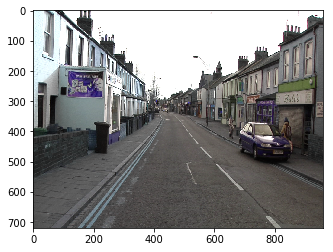

In [8]:
temp_img = cv2.imread("../input/camvid/CamVid/val/Seq05VD_f03780.png") #3 channels / spectral bands
plt.imshow(temp_img)
temp_img.shape

Labels are:  [  0  64 128 192]  and the counts are:  [ 701558  237976 1023641  110425]
(720, 960, 3)


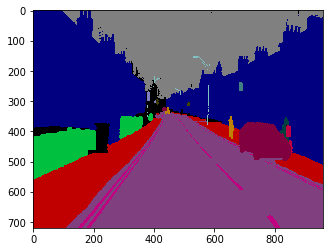

In [34]:
temp_mask = cv2.imread("../input/camvid/CamVid/val_labels/Seq05VD_f03780_L.png") #3 channels but all same.
# temp_mask = cv2.cvtColor(temp_mask, cv2.COLOR_BGR2GRAY)
# sf = 1
# # Resize the mask
# scaled_mask = cv2.resize(temp_mask_gray, None, fx=sf, fy=sf, interpolation=cv2.INTER_AREA)
plt.imshow(temp_mask)
labels, count = np.unique(temp_mask, return_counts=True)
print("Labels are: ", labels, " and the counts are: ", count)
print(temp_mask.shape)

In [35]:
# NOW WE ARE CHECKING WHETHER EACH IMAGE HAS ITS CORRESPONDING LABEL IN ITS RESPECTIVE FOLDER OR NOT
for im in train_imgs:
    assert dataset_path / "train_labels" / (im.stem +"_L.png") in train_labels , "{im} not there in label folder"
for im in val_imgs:
    assert dataset_path / "val_labels" / (im.stem +"_L.png") in val_labels , "{im} not there in label folder"
for im in test_imgs:
    assert dataset_path / "test_labels" / (im.stem +"_L.png") in test_labels , "{im} not there in label folder"

In [36]:
# NOW WE ARE MAKING THE PAIRS OF THE IMAGE WITH ITS CORRESPONDING LABEL 
def make_pair(img,label,dataset):
    pairs = []
    for im in img:
        pairs.append((im , dataset / label / (im.stem +"_L.png")))
    
    return pairs

In [37]:
train_pair = make_pair(train_imgs, "train_labels", dataset_path)
val_pair = make_pair(val_imgs, "val_labels", dataset_path)
test_pair = make_pair(test_imgs, "test_labels", dataset_path)
len(train_pair), len(val_pair), len(test_pair)

(421, 112, 168)

In [38]:
train_pair[:5]

[(PosixPath('../input/camvid/CamVid/train/0001TP_009780.png'),
  PosixPath('../input/camvid/CamVid/train_labels/0001TP_009780_L.png')),
 (PosixPath('../input/camvid/CamVid/train/0016E5_07963.png'),
  PosixPath('../input/camvid/CamVid/train_labels/0016E5_07963_L.png')),
 (PosixPath('../input/camvid/CamVid/train/Seq05VD_f01950.png'),
  PosixPath('../input/camvid/CamVid/train_labels/Seq05VD_f01950_L.png')),
 (PosixPath('../input/camvid/CamVid/train/Seq05VD_f01590.png'),
  PosixPath('../input/camvid/CamVid/train_labels/Seq05VD_f01590_L.png')),
 (PosixPath('../input/camvid/CamVid/train/0016E5_02070.png'),
  PosixPath('../input/camvid/CamVid/train_labels/0016E5_02070_L.png'))]

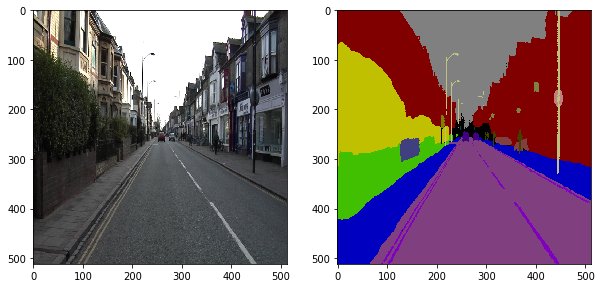

In [64]:
temp = choice(train_pair)
img = img_to_array(load_img(temp[0], target_size=(img_size,img_size)))
mask = img_to_array(load_img(temp[1], target_size = (img_size,img_size)))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img/255)
plt.subplot(122)
plt.imshow(mask/255)

In [65]:
labels22, count22 = np.unique(mask/255, return_counts=True)
print("Labels are: ", labels22, " and the counts are: ", count22)
mask.shape

Labels are:  [0.        0.2509804 0.5019608 0.7529412]  and the counts are:  [252645  94719 335075 103993]


(512, 512, 3)

In [66]:
class_map_df = pd.read_csv(dataset_path / "class_dict.csv")

In [67]:
class_map = []
for index,item in class_map_df.iterrows():
    class_map.append(np.array([item['r'], item['g'], item['b']]))
    
print(len(class_map))
class_map

32


[array([ 64, 128,  64]),
 array([192,   0, 128]),
 array([  0, 128, 192]),
 array([  0, 128,  64]),
 array([128,   0,   0]),
 array([ 64,   0, 128]),
 array([ 64,   0, 192]),
 array([192, 128,  64]),
 array([192, 192, 128]),
 array([ 64,  64, 128]),
 array([128,   0, 192]),
 array([192,   0,  64]),
 array([128, 128,  64]),
 array([192,   0, 192]),
 array([128,  64,  64]),
 array([ 64, 192, 128]),
 array([64, 64,  0]),
 array([128,  64, 128]),
 array([128, 128, 192]),
 array([  0,   0, 192]),
 array([192, 128, 128]),
 array([128, 128, 128]),
 array([ 64, 128, 192]),
 array([ 0,  0, 64]),
 array([ 0, 64, 64]),
 array([192,  64, 128]),
 array([128, 128,   0]),
 array([192, 128, 192]),
 array([64,  0, 64]),
 array([192, 192,   0]),
 array([0, 0, 0]),
 array([ 64, 192,   0])]

In [68]:
'''The purpose of this code is to ensure that all values in the mask array fall within
the expected range of classes defined by class_map.
 If any value in the mask is not found in class_map, an assertion error will be raised,
 indicating which value is causing the issue.
''' 
def assert_map_range(mask,class_map):
    mask = mask.astype("uint8")
    for j in range(img_size):
        for k in range(img_size):
            assert mask[j][k] in class_map , tuple(mask[j][k])

In [69]:
'''Inside the loop:
(mask == rgb).all(axis=2) creates a boolean mask where each element is True if 
the corresponding pixel in mask has RGB values matching the current rgb class, and False otherwise.
label[(mask == rgb).all(axis=2)] = i assigns the index i to the 
corresponding pixels in the label array where the boolean mask is True.
'''
def form_2D_label(mask,class_map):
    mask = mask.astype("uint8")
    label = np.zeros(mask.shape[:2],dtype= np.uint8)
    
    for i, rgb in enumerate(class_map):
        label[(mask == rgb).all(axis=2)] = i
    
    return label

In [88]:
lab = form_2D_label(mask,class_map)
print(np.unique(lab,return_counts=True))
lal = to_categorical(lab , num_classes = 32)
lal.shape

(array([ 4,  5,  8,  9, 10, 12, 14, 16, 17, 19, 20, 21, 24, 26, 29, 30, 31],
      dtype=uint8), array([73278,   477,  2137,  1483,  3178,   341,   925,   474, 72341,
       26262,   373, 35707,    36,   183, 27091,  2134, 15724]))


(512, 512, 32)

In [89]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, pair, class_map, batch_size=16, dim=(224,224,3), shuffle=True):
        'Initialization'
        self.dim = dim
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.pair))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.pair[i][0] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            label = load_img(self.pair[i][1],target_size=self.dim)
            label = img_to_array(label)
            label = form_2D_label(label,self.class_map)
            label = to_categorical(label , num_classes = 32)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

In [90]:
train_generator = DataGenerator(train_pair+test_pair,class_map,batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

147

In [92]:
X,y = train_generator.__getitem__(1)
y.shape

(4, 512, 512, 32)

In [93]:
val_generator = DataGenerator(val_pair, class_map, batch_size=4, dim=(img_size,img_size,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

28

In [94]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=32, kernel_size=(1, 1), activation='softmax')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [95]:
model = Unet(img_size , img_size , 64)
model.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 1792        image_input[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________________

In [111]:
import tensorflow
model.compile(optimizer='adam', loss='categorical_crossentropy' ,metrics=['accuracy', tensorflow.keras.metrics.MeanIoU(num_classes=32)])

In [112]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_acc',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_acc', patience=10, verbose=0)
tb = TensorBoard(log_dir="logs/", histogram_freq=0, write_graph=True, write_images=False)
rl = ReduceLROnPlateau(monitor='val_acc',factor=0.1,patience=5,verbose=1,mode="max",min_lr=0.0001)
cv = CSVLogger("logs/log.csv" , append=True , separator=',')

In [113]:
results = model.fit_generator(train_generator , steps_per_epoch=train_steps ,epochs=30,
                              validation_data=val_generator,validation_steps=val_steps,callbacks=[mc,es,tb,rl,cv])

Epoch 1/30
146/147 [============================>.] - ETA: 1s - loss: 1.3698 - acc: 0.6315 - mean_io_u_1: 0.4844
Epoch 00001: val_acc improved from -inf to 0.39356, saving model to top-weights.h5
147/147 [==============================] - 279s 2s/step - loss: 1.3676 - acc: 0.6319 - mean_io_u_1: 0.4844 - val_loss: 6.0638 - val_acc: 0.3936 - val_mean_io_u_1: 0.4844
Epoch 2/30
146/147 [============================>.] - ETA: 1s - loss: 0.9296 - acc: 0.7361 - mean_io_u_1: 0.4844
Epoch 00002: val_acc improved from 0.39356 to 0.68558, saving model to top-weights.h5
147/147 [==============================] - 239s 2s/step - loss: 0.9288 - acc: 0.7363 - mean_io_u_1: 0.4844 - val_loss: 1.3275 - val_acc: 0.6856 - val_mean_io_u_1: 0.4844
Epoch 3/30
146/147 [============================>.] - ETA: 1s - loss: 0.8028 - acc: 0.7741 - mean_io_u_1: 0.4844
Epoch 00003: val_acc improved from 0.68558 to 0.75216, saving model to top-weights.h5
147/147 [==============================] - 239s 2s/step - loss: 0.

In [122]:
img_mask = choice(val_pair)
img= img_to_array(load_img(img_mask[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask[1] , target_size= (img_size,img_size)))

In [123]:
def make_prediction(model,img_path,shape):
    img= img_to_array(load_img(img_path , target_size= shape))/255.
    img = np.expand_dims(img,axis=0)
    labels = model.predict(img)
    labels = np.argmax(labels[0],axis=2)
    return labels

In [124]:
pred_label = make_prediction(model, img_mask[0], (img_size,img_size,3))
pred_label.shape

(512, 512)

In [125]:
def form_colormap(prediction,mapping):
    h,w = prediction.shape
    color_label = np.zeros((h,w,3),dtype=np.uint8)    
    color_label = mapping[prediction]
    color_label = color_label.astype(np.uint8)
    return color_label

In [126]:
pred_colored = form_colormap(pred_label,np.array(class_map))

Text(0.5, 1.0, 'predicted labels')

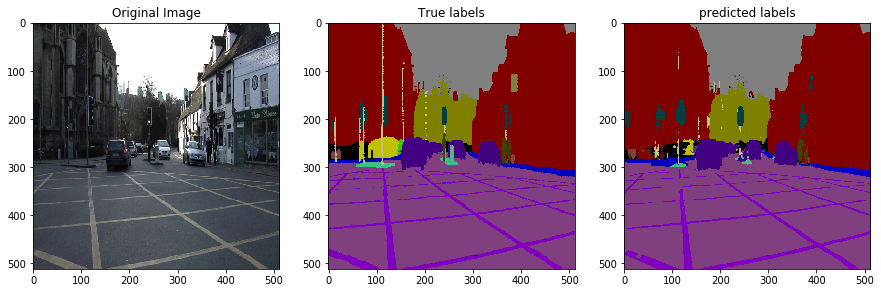

In [127]:
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255.)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255.)
plt.subplot(133)
plt.imshow(pred_colored/255.);plt.title('predicted labels')

In [130]:
from sklearn.metrics import confusion_matrix

# Function to calculate IoU for each class
def calculate_iou(y_true, y_pred, num_classes):
    iou_list = []

    for class_id in range(num_classes):
        true_positive = np.sum((y_true == class_id) & (y_pred == class_id))
        false_positive = np.sum((y_true != class_id) & (y_pred == class_id))
        false_negative = np.sum((y_true == class_id) & (y_pred != class_id))

        # IoU (Jaccard Index) for the current class
        iou = true_positive / (true_positive + false_positive + false_negative + 1e-10)
        iou_list.append(iou)

    return iou_list

# Load the ground truth label
gt_label = form_2D_label(gt_img, class_map)

# Calculate IoU for each class
iou_scores = calculate_iou(gt_label.flatten(), pred_label.flatten(), num_classes=32)

# Print IoU scores for each class
for class_id, iou in enumerate(iou_scores):
    if iou == 0:
        continue
    else:
        print(f"IoU for Class {class_id}: {iou:.4f}")

# Average IoU
average_iou = np.mean(iou_scores)
print(f"\nAverage IoU: {average_iou:.4f}")



IoU for Class 4: 0.9320
IoU for Class 5: 0.8376
IoU for Class 8: 0.1592
IoU for Class 10: 0.8207
IoU for Class 14: 0.3299
IoU for Class 15: 0.2924
IoU for Class 16: 0.4321
IoU for Class 17: 0.9610
IoU for Class 19: 0.6263
IoU for Class 21: 0.9859
IoU for Class 24: 0.5318
IoU for Class 26: 0.8847
IoU for Class 29: 0.2032
IoU for Class 30: 0.1505

Average IoU: 0.2546


In [151]:
img_mask2 = choice(val_pair)
img= img_to_array(load_img(img_mask2[0] , target_size= (img_size,img_size)))
gt_img = img_to_array(load_img(img_mask2[1] , target_size= (img_size,img_size)))
pred_label = make_prediction(model, img_mask2[0], (img_size,img_size,3))
pred_label.shape
pred_colored = form_colormap(pred_label,np.array(class_map))
plt.figure(figsize=(15,15))
plt.subplot(131);plt.title('Original Image')
plt.imshow(img/255)
plt.subplot(132);plt.title('True labels')
plt.imshow(gt_img/255)
plt.subplot(133)
plt.imshow(pred_colored/255);plt.title('predicted labels')

TypeError: an integer is required (got type tuple)